In [1]:
from utils.imports import *

Using TensorFlow backend.


In [2]:
csv_path = PATH['annotations_val']
src = PATH['model_train_pred']
pred_csv_path = PATH['model_train_pred']
data_path = PATH['src_train']

In [3]:
model_paths = PATH['model_paths']
model_final = PATH['model_final']

In [4]:
model_cube_30 = load_model(model_paths + 'Fenge_32_32_32_0703.h5')
clf = joblib.load('classifymodel.pkl')

In [5]:
test_pred_0 = pd.read_csv(pred_csv_path + "1final_result.csv")

In [6]:
seriesuids = pd.read_csv(PATH['annotations_val'] + "seriesuids.csv")
test_pred_0["file"] = test_pred_0["seriesuid"].map(lambda file_name:  get_filename(seriesuids['seriesuid'].values, file_name))
test_pred_0 = test_pred_0.dropna()

In [7]:
patients = [x for x in os.listdir(pred_csv_path) if 'orig' in x]   

In [8]:
test_pred_0["file"] = test_pred_0["seriesuid"].map(lambda file_name: get_filename(patients, file_name))
test_pred_0 = test_pred_0.dropna()

In [9]:
def get_dirfiles(dir):
    file_list = []
    subset_path = os.listdir(dir)
    for _ in range(len(subset_path)):
        if subset_path[_] != '.DS_Store':
            file_list.append(dir + subset_path[_])
    return file_list

def getRegionFromMap(slice_npy):
    #thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
    label_image = measure.label(slice_npy)
    labels = label_image.astype(int)
    regions = measure.regionprops(labels)
    return regions

def getRegionMetricRow(fname,model):
    # fname, numpy array of dimension [#slices, 1, 512, 512] containing the images
    
    seg = np.load(fname)
    nslices = seg.shape[0]
    
    #metrics
    totalArea = 0.
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.
    prob = 0.
    seg_prob = np.expand_dims(seg,0)
    seg_prob = np.expand_dims(seg_prob,0)
    # crude hueristic to filter some bad segmentaitons
    # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
    maxAllowedArea = 0.10 * 512 * 512 
    
    areas = []
    eqDiameters = []
    seg = np.expand_dims(seg,1)
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen,0,:,:])
        for region in regions:
            if region.area > maxAllowedArea:
                continue
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            avgEquivlentDiameter += region.equivalent_diameter
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1
    if totalArea == 0 or numNodes == 0:
        os.remove(fname)
    else:
        weightedX = weightedX / totalArea 
        weightedY = weightedY / totalArea
        avgArea = totalArea / numNodes
        avgEcc = avgEcc / numNodes
        avgEquivlentDiameter = avgEquivlentDiameter / numNodes
        stdEquivlentDiameter = np.std(eqDiameters)

        maxArea = max(areas)


        numNodesperSlice = numNodes*1. / nslices

        prob = model.predict(seg_prob)[0][1]
        return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                         stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice, prob])

In [10]:
def get_cube_from_img(img3d, center_x, center_y, center_z, block_size):
    start_x = max(center_x - block_size / 2, 0)
    if start_x + block_size > img3d.shape[2]:
        start_x = img3d.shape[2] - block_size

    start_y = max(center_y - block_size / 2, 0)
    start_z = max(center_z - block_size / 2, 0)
    if start_z + block_size > img3d.shape[0]:
        start_z = img3d.shape[0] - block_size
    start_z = int(start_z)
    start_y = int(start_y)
    start_x = int(start_x)
    res = img3d[start_z:start_z + block_size, start_y:start_y + block_size, start_x:start_x + block_size]
    if res.shape != (32, 32, 32):
        res = resize(res,[32,32,32],mode='nearest')
    return res  


probability_30_30_30_cube = []

average = []

for img_file in tqdm(sorted(patients)):
    mini_df_anno = test_pred_0[test_pred_0["file"]==img_file] #get all nodules associate with file
    if mini_df_anno.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once        
        patient_id = img_file[:-9]
        img_array = np.load(src + img_file)
        pos_annos = pd.read_csv(src + img_file[:-9] + '_annos_pos.csv')
        origin = np.array([pos_annos.loc[0]['origin_x'],pos_annos.loc[0]['origin_y'],pos_annos.loc[0]['origin_z']]) 
        spacing = np.array([pos_annos.loc[0]['spacing_x'],pos_annos.loc[0]['spacing_y'],pos_annos.loc[0]['spacing_z']])
        img_array = normalize(img_array)                
        for node_idx1, cur_row1 in mini_df_anno.iterrows():       
            node_x = cur_row1["coordX"]
            node_y = cur_row1["coordY"]
            node_z = cur_row1["coordZ"]
            diam = cur_row1["diameter_mm"]
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint(np.absolute(center-origin)/spacing)            
            new_x = int(v_center[0])
            new_y = int(v_center[1])
            new_z = int(v_center[2])  
            d = int(diam*3+1)
            if True:

                seg = get_cube_from_img(img_array, new_x, new_y, new_z, d)  
            
                nslices = seg.shape[0]

                #metrics
                totalArea = 0.
                avgArea = 0.
                maxArea = 0.
                avgEcc = 0.
                avgEquivlentDiameter = 0.
                stdEquivlentDiameter = 0.
                weightedX = 0.
                weightedY = 0.
                numNodes = 0.
                numNodesperSlice = 0.
                # crude hueristic to filter some bad segmentaitons
                # do not allow any nodes to be larger than 10% of the pixels to eliminate background regions
                maxAllowedArea = 0.10 * 512 * 512 

                prob = 0.
                seg_prob = np.expand_dims(seg,0)
                seg_prob = np.expand_dims(seg_prob,0)                
                
                
                areas = []
                eqDiameters = []
                seg = np.expand_dims(seg,1)
                for slicen in range(nslices):
                    regions = getRegionFromMap(seg[slicen,0,:,:])
                    for region in regions:
                        if region.area > maxAllowedArea:
                            continue
                        totalArea += region.area
                        areas.append(region.area)
                        avgEcc += region.eccentricity
                        avgEquivlentDiameter += region.equivalent_diameter
                        eqDiameters.append(region.equivalent_diameter)
                        weightedX += region.centroid[0]*region.area
                        weightedY += region.centroid[1]*region.area
                        numNodes += 1
                if totalArea == 0 or numNodes == 0:
                    cls_result_cube_30 = int(0)
                else:
                    weightedX = weightedX / totalArea 
                    weightedY = weightedY / totalArea
                    avgArea = totalArea / numNodes
                    avgEcc = avgEcc / numNodes
                    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
                    stdEquivlentDiameter = np.std(eqDiameters)

                    maxArea = max(areas)


                    numNodesperSlice = numNodes*1. / nslices
                    
                    prob = model_cube_30.predict(seg_prob)[0][1]

                    feature =  np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice,prob])
                    cls_result_cube_30 = clf.predict_proba(np.expand_dims(feature,0))[0][1]
            probability_30_30_30_cube.append(cls_result_cube_30)

100%|██████████| 800/800 [16:01<00:00,  1.20s/it]


In [11]:
probability_30_30_30_cube = np.array(probability_30_30_30_cube)
probability_30_30_30_cube = probability_30_30_30_cube.clip(0.005,0.995)
probability_30_30_30_cube = probability_30_30_30_cube.round(3)
test_pred_0['probability'] = probability_30_30_30_cube

In [16]:
test_pred_0.to_csv(main_path + "/evaluationScript/exampleFiles/val_cal_2.csv", index=False)

/Volumes/solo/ali/evaluationScript/annotations/annotations_all.csv
adding nodule annotations: seriesuid
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00539
adding nodule annotations: LKDS-00340
adding nodule annotations: LKDS-00737
adding nodule annotations: LKDS-00008
adding nodule annotations: LKDS-00685
adding nodule annotations: LKDS-00146
adding nodule annotations: LKDS-00791
adding nodule annotations: LKDS-00409
adding nodule annotations: LKDS-00311
adding nodule annotations: LKDS-00228
adding nodule annotations: LKDS-00141
adding nodule annotations: LKDS-00415
adding nodule annotations: LKDS-00210
adding nodule annotations: LKDS-00522
adding nodule annotations: LKDS-00522
adding nodule annotations: LKDS-00522
adding nodule annotations: LKDS-00522
adding nodule annotati

adding candidates: LKDS-00146
adding candidates: LKDS-00791
adding candidates: LKDS-00409
adding candidates: LKDS-00311
adding candidates: LKDS-00228
adding candidates: LKDS-00141
adding candidates: LKDS-00415
adding candidates: LKDS-00210
adding candidates: LKDS-00522
adding candidates: LKDS-00522
adding candidates: LKDS-00522
adding candidates: LKDS-00522
adding candidates: LKDS-00522
adding candidates: LKDS-00686
adding candidates: LKDS-00858
adding candidates: LKDS-00858
adding candidates: LKDS-00432
adding candidates: LKDS-00367
adding candidates: LKDS-00433
adding candidates: LKDS-00060
adding candidates: LKDS-00988
adding candidates: LKDS-00166
adding candidates: LKDS-00793
adding candidates: LKDS-00391
adding candidates: LKDS-00391
adding candidates: LKDS-00327
adding candidates: LKDS-00157
adding candidates: LKDS-00226
adding candidates: LKDS-00928
adding candidates: LKDS-00310
adding candidates: LKDS-00715
adding candidates: LKDS-00729
adding candidates: LKDS-00121
adding can

computing FROC: bootstrap 1/1000
computing FROC: bootstrap 2/1000
computing FROC: bootstrap 3/1000
computing FROC: bootstrap 4/1000
computing FROC: bootstrap 5/1000
computing FROC: bootstrap 6/1000
computing FROC: bootstrap 7/1000
computing FROC: bootstrap 8/1000
computing FROC: bootstrap 9/1000
computing FROC: bootstrap 10/1000
computing FROC: bootstrap 11/1000
computing FROC: bootstrap 12/1000
computing FROC: bootstrap 13/1000
computing FROC: bootstrap 14/1000
computing FROC: bootstrap 15/1000
computing FROC: bootstrap 16/1000
computing FROC: bootstrap 17/1000
computing FROC: bootstrap 18/1000
computing FROC: bootstrap 19/1000
computing FROC: bootstrap 20/1000
computing FROC: bootstrap 21/1000
computing FROC: bootstrap 22/1000
computing FROC: bootstrap 23/1000
computing FROC: bootstrap 24/1000
computing FROC: bootstrap 25/1000
computing FROC: bootstrap 26/1000
computing FROC: bootstrap 27/1000
computing FROC: bootstrap 28/1000
computing FROC: bootstrap 29/1000
computing FROC: bootstr

computing FROC: bootstrap 241/1000
computing FROC: bootstrap 242/1000
computing FROC: bootstrap 243/1000
computing FROC: bootstrap 244/1000
computing FROC: bootstrap 245/1000
computing FROC: bootstrap 246/1000
computing FROC: bootstrap 247/1000
computing FROC: bootstrap 248/1000
computing FROC: bootstrap 249/1000
computing FROC: bootstrap 250/1000
computing FROC: bootstrap 251/1000
computing FROC: bootstrap 252/1000
computing FROC: bootstrap 253/1000
computing FROC: bootstrap 254/1000
computing FROC: bootstrap 255/1000
computing FROC: bootstrap 256/1000
computing FROC: bootstrap 257/1000
computing FROC: bootstrap 258/1000
computing FROC: bootstrap 259/1000
computing FROC: bootstrap 260/1000
computing FROC: bootstrap 261/1000
computing FROC: bootstrap 262/1000
computing FROC: bootstrap 263/1000
computing FROC: bootstrap 264/1000
computing FROC: bootstrap 265/1000
computing FROC: bootstrap 266/1000
computing FROC: bootstrap 267/1000
computing FROC: bootstrap 268/1000
computing FROC: boot

computing FROC: bootstrap 476/1000
computing FROC: bootstrap 477/1000
computing FROC: bootstrap 478/1000
computing FROC: bootstrap 479/1000
computing FROC: bootstrap 480/1000
computing FROC: bootstrap 481/1000
computing FROC: bootstrap 482/1000
computing FROC: bootstrap 483/1000
computing FROC: bootstrap 484/1000
computing FROC: bootstrap 485/1000
computing FROC: bootstrap 486/1000
computing FROC: bootstrap 487/1000
computing FROC: bootstrap 488/1000
computing FROC: bootstrap 489/1000
computing FROC: bootstrap 490/1000
computing FROC: bootstrap 491/1000
computing FROC: bootstrap 492/1000
computing FROC: bootstrap 493/1000
computing FROC: bootstrap 494/1000
computing FROC: bootstrap 495/1000
computing FROC: bootstrap 496/1000
computing FROC: bootstrap 497/1000
computing FROC: bootstrap 498/1000
computing FROC: bootstrap 499/1000
computing FROC: bootstrap 500/1000
computing FROC: bootstrap 501/1000
computing FROC: bootstrap 502/1000
computing FROC: bootstrap 503/1000
computing FROC: boot

computing FROC: bootstrap 712/1000
computing FROC: bootstrap 713/1000
computing FROC: bootstrap 714/1000
computing FROC: bootstrap 715/1000
computing FROC: bootstrap 716/1000
computing FROC: bootstrap 717/1000
computing FROC: bootstrap 718/1000
computing FROC: bootstrap 719/1000
computing FROC: bootstrap 720/1000
computing FROC: bootstrap 721/1000
computing FROC: bootstrap 722/1000
computing FROC: bootstrap 723/1000
computing FROC: bootstrap 724/1000
computing FROC: bootstrap 725/1000
computing FROC: bootstrap 726/1000
computing FROC: bootstrap 727/1000
computing FROC: bootstrap 728/1000
computing FROC: bootstrap 729/1000
computing FROC: bootstrap 730/1000
computing FROC: bootstrap 731/1000
computing FROC: bootstrap 732/1000
computing FROC: bootstrap 733/1000
computing FROC: bootstrap 734/1000
computing FROC: bootstrap 735/1000
computing FROC: bootstrap 736/1000
computing FROC: bootstrap 737/1000
computing FROC: bootstrap 738/1000
computing FROC: bootstrap 739/1000
computing FROC: boot

computing FROC: bootstrap 949/1000
computing FROC: bootstrap 950/1000
computing FROC: bootstrap 951/1000
computing FROC: bootstrap 952/1000
computing FROC: bootstrap 953/1000
computing FROC: bootstrap 954/1000
computing FROC: bootstrap 955/1000
computing FROC: bootstrap 956/1000
computing FROC: bootstrap 957/1000
computing FROC: bootstrap 958/1000
computing FROC: bootstrap 959/1000
computing FROC: bootstrap 960/1000
computing FROC: bootstrap 961/1000
computing FROC: bootstrap 962/1000
computing FROC: bootstrap 963/1000
computing FROC: bootstrap 964/1000
computing FROC: bootstrap 965/1000
computing FROC: bootstrap 966/1000
computing FROC: bootstrap 967/1000
computing FROC: bootstrap 968/1000
computing FROC: bootstrap 969/1000
computing FROC: bootstrap 970/1000
computing FROC: bootstrap 971/1000
computing FROC: bootstrap 972/1000
computing FROC: bootstrap 973/1000
computing FROC: bootstrap 974/1000
computing FROC: bootstrap 975/1000
computing FROC: bootstrap 976/1000
computing FROC: boot

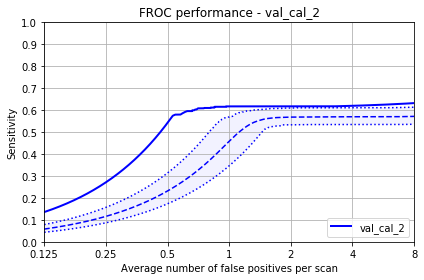

In [17]:
%run ./evaluationScript/noduleCADEvaluationLUNA16.py

In [18]:
result = plt.imread('/Volumes/solo/ali/evaluationScript/froc_val_cal_2.png')

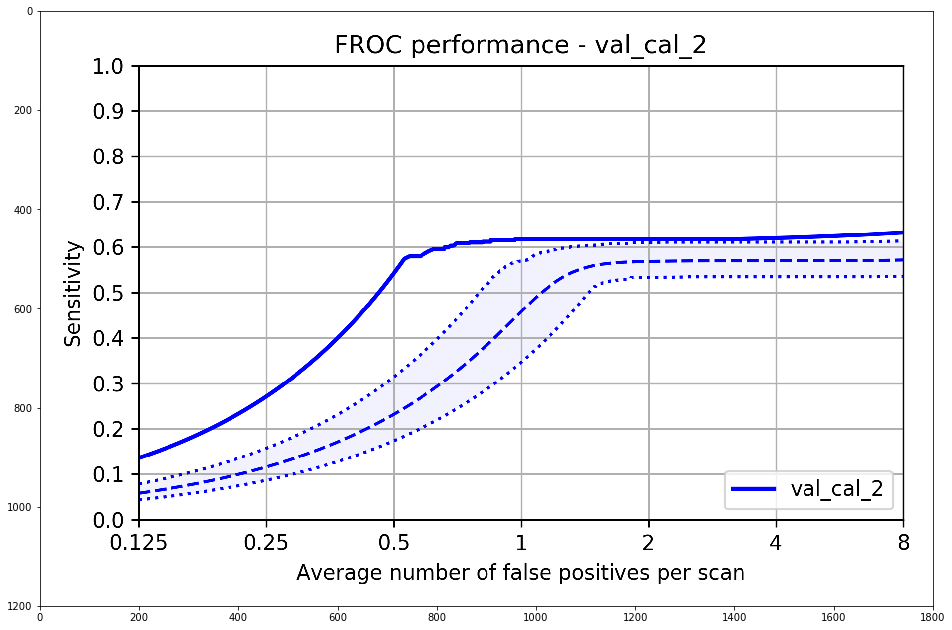

In [19]:
%matplotlib inline
plt.figure(num='result',figsize=(16,16))
plt.imshow(result)